In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import time
import tensorflow as tf
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def get_data():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    return X, y

In [18]:
def get_matrix(y_true, y_score, threshold=.5):
    y_pred = y_score >= threshold

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    return tp, tn, fp, fn

In [19]:
def get_metrics(tp, tn, fp, fn):
    prevalence = (tp + fn) / (tp + tn + fp + fn)
    sensibility = tp / (tp + fn)
    specificity = tn / (fp + tn)

    return prevalence, sensibility, specificity

In [20]:
def specificity(y_true, y_score):
    threshold = 0.5
    y_pred = tf.cast(tf.greater_equal(y_score, threshold), tf.float32)

    true_negatives = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))
    num_true_negatives = tf.reduce_sum(tf.cast(true_negatives, tf.float32))

    negatives = tf.equal(y_true, 0)
    num_negatives = tf.reduce_sum(tf.cast(negatives, tf.float32))

    specificity = num_true_negatives / (num_negatives + tf.keras.backend.epsilon())

    return specificity

In [21]:
def compile_fit(net, x, y, first_layer, optimizer, learning_rate):
    tf.keras.utils.set_random_seed(5)
    layers = net
    model = Sequential()

    for idx, layer in enumerate(layers):
        if idx == 0:
            model.add(Dense(layer, activation='elu', input_dim=first_layer))
        elif idx == len(layers) - 1:
            model.add(Dense(layer, activation='sigmoid'))
        else:
            model.add(Dense(layer, activation='elu'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rate),
                  metrics=['Recall', 'AUC', specificity])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    mark1 = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=False)
    mark2 = time.time()

    time_elapsed = mark2 - mark1

    return model, history, time_elapsed

In [22]:
def plot_metrics(figure, history, title):
    axe_loss = figure.add_subplot(2, 2, 1)
    axe_loss.plot(
        history['loss'], linestyle='dotted', color="#003B80", label=f'loss entrenamiento {history["loss"][-1]:.2f}'
    )
    axe_loss.plot(history['val_loss'], color="#003B80", label=f'loss validacion {history["val_loss"][-1]:.2f}')

    axe_loss.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_loss.xaxis.set_major_locator(MultipleLocator(3))

    axe_loss.set_ylabel('Perdida', color='#003B80', fontsize=13)
    axe_loss.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_loss.set_ylim(ymin=0, ymax=1.1)

    axe_loss.set_title('loss')
    axe_loss.set_facecolor("#E3F7FA")
    axe_loss.grid(visible=True, which='major', axis='both', color='white')
    axe_loss.set_axisbelow(True)
    axe_loss.legend()

    axe_recall = figure.add_subplot(2, 2, 2)
    axe_recall.plot(
        history['recall'], linestyle='dotted', color="#003B80",
        label=f'recall entrenamiento {history["recall"][-1]:.2f}'
    )
    axe_recall.plot(history['val_recall'], color="#003B80", label=f'recall validacion {history["val_recall"][-1]:.2f}')

    axe_recall.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_recall.xaxis.set_major_locator(MultipleLocator(3))

    axe_recall.set_ylabel('Recall', color='#003B80', fontsize=13)
    axe_recall.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_recall.set_ylim(ymin=0, ymax=1.1)

    axe_recall.set_title('recall')
    axe_recall.set_facecolor("#E3F7FA")
    axe_recall.grid(visible=True, which='major', axis='both', color='white')
    axe_recall.set_axisbelow(True)
    axe_recall.legend()

    axe_specificity = figure.add_subplot(2, 2, 3)
    axe_specificity.plot(
        history['specificity'], linestyle='dotted', color="#003B80",
        label=f'specificity entrenamiento {history["specificity"][-1]:.2f}'
    )
    axe_specificity.plot(history['val_specificity'], color="#003B80",
                         label=f'specificity validacion {history["val_specificity"][-1]:.2f}')

    axe_specificity.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_specificity.xaxis.set_major_locator(MultipleLocator(3))

    axe_specificity.set_ylabel('Specificity', color='#003B80', fontsize=13)
    axe_specificity.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_specificity.set_ylim(ymin=0, ymax=1.1)

    axe_specificity.set_title('specificity')
    axe_specificity.set_facecolor("#E3F7FA")
    axe_specificity.grid(visible=True, which='major', axis='both', color='white')
    axe_specificity.set_axisbelow(True)
    axe_specificity.legend()

    axe_auc = figure.add_subplot(2, 2, 4)
    axe_auc.plot(
        history['auc'], linestyle='dotted', color="#003B80",
        label=f'AUC entrenamiento {history["auc"][-1]:.2f}'
    )
    axe_auc.plot(history['val_auc'], color="#003B80", label=f'AUC validacion {history["val_auc"][-1]:.2f}')

    axe_auc.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_auc.xaxis.set_major_locator(MultipleLocator(3))

    axe_auc.set_ylabel('AUC', color='#003B80', fontsize=13)
    axe_auc.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_auc.set_ylim(ymin=0, ymax=1.1)

    axe_auc.set_title('AUC')
    axe_auc.set_facecolor("#E3F7FA")
    axe_auc.grid(visible=True, which='major', axis='both', color='white')
    axe_auc.set_axisbelow(True)
    axe_auc.legend()

In [23]:
X, y = get_data()

In [24]:
model_trained, history, time_elapsed = compile_fit([30, 64, 32, 16, 8, 1], X, y, 30, tf.keras.optimizers.Adam, 0.0001)

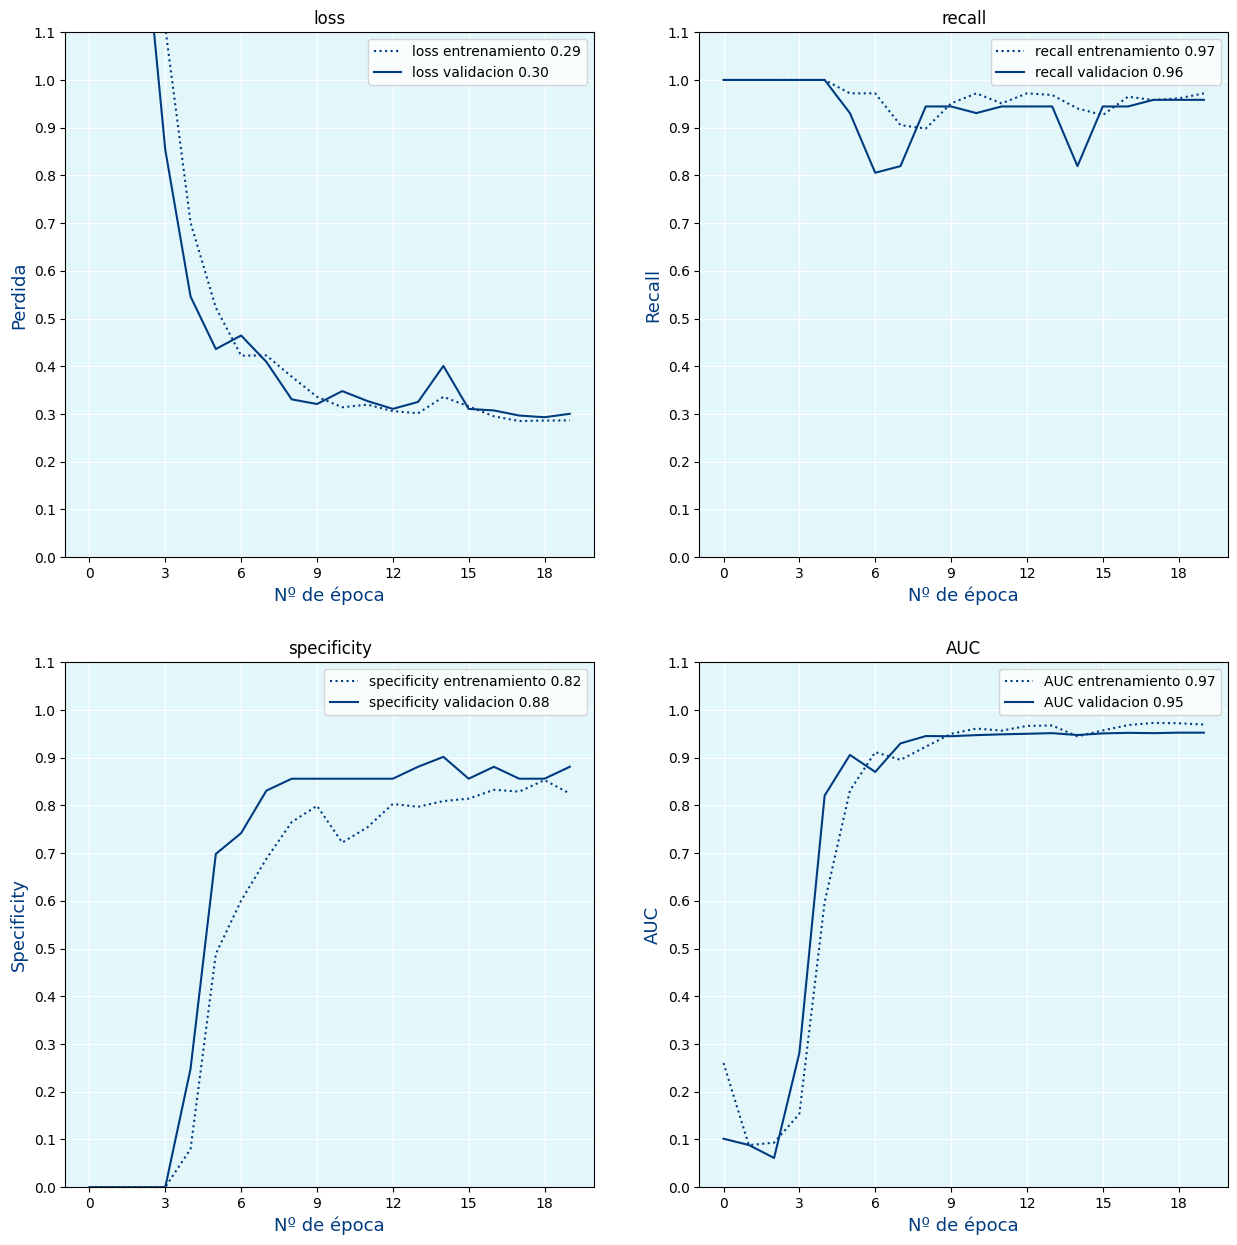

In [25]:
figure = plt.figure(figsize=(15, 15))

plot_metrics(figure, history.history, 'Red Neuronal')

In [26]:
model_trained.save('model.h5')

C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
threshold_sample = np.linspace(0, 1, 500)

y_score = model_trained.predict(X).reshape(-1)

sensibility_sample = []
specificity_sample = []

for threshold in threshold_sample:
    tp, tn, fp, fn = get_matrix(y, y_score, threshold)
    _, sensibility, specificity = get_metrics(tp, tn, fp, fn)

    sensibility_sample.append(sensibility)
    specificity_sample.append(specificity)

18/18 [==============================] - 0s 810us/step


In [29]:
y_score

array([0.2550867 , 0.25452122, 0.25359434, 0.8112472 , 0.26205528,
       0.31462947, 0.25402492, 0.2777165 , 0.5011758 , 0.5052563 ,
       0.25489882, 0.25543922, 0.35797524, 0.8039307 , 0.90046734,
       0.2720466 , 0.25659534, 0.25539908, 0.25374368, 0.71572304,
       0.86374354, 0.95596105, 0.2935915 , 0.2535131 , 0.25924027,
       0.25582746, 0.29929072, 0.2562875 , 0.25463572, 0.2639172 ,
       0.25357336, 0.2813214 , 0.25420785, 0.2537043 , 0.2549148 ,
       0.25482947, 0.66485924, 0.9068153 , 0.75440437, 0.58656704,
       0.32107264, 0.8635327 , 0.25362447, 0.26375338, 0.4353206 ,
       0.2537613 , 0.966769  , 0.3849563 , 0.82264185, 0.78909296,
       0.94148165, 0.87832665, 0.9165964 , 0.25883105, 0.25641248,
       0.9216311 , 0.2536864 , 0.25963733, 0.8963228 , 0.9570343 ,
       0.9474227 , 0.9732188 , 0.2736903 , 0.9623745 , 0.2670963 ,
       0.29135883, 0.97105074, 0.9505358 , 0.95521533, 0.931768  ,
       0.253486  , 0.95199853, 0.25371075, 0.35552806, 0.78443

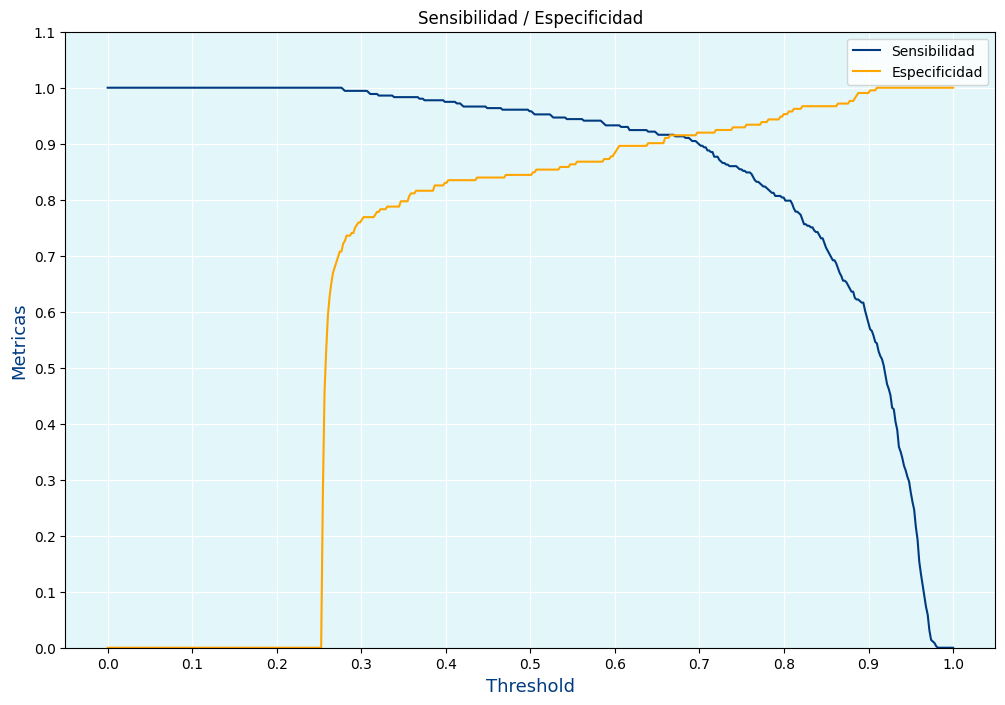

In [28]:
# Plot sensitivity and specificity
figure = plt.figure(figsize=(12, 8))

axe = figure.add_subplot(1, 1, 1)
axe.plot(threshold_sample, sensibility_sample, color="#003B80", label='Sensibilidad')
axe.plot(threshold_sample, specificity_sample, color="#FFA500", label='Especificidad')

axe.set_xlabel('Threshold', color='#003B80', fontsize=13)
axe.xaxis.set_major_locator(MultipleLocator(0.1))

axe.set_ylabel('Metricas', color='#003B80', fontsize=13)
axe.yaxis.set_major_locator(MultipleLocator(0.1))
axe.set_ylim(ymin=0, ymax=1.1)

axe.set_title('Sensibilidad / Especificidad')
axe.set_facecolor("#E3F7FA")
axe.grid(visible=True, which='major', axis='both', color='white')
axe.set_axisbelow(True)
axe.legend()

# Threshold = 0.5
tp = 30
tn = 20
fp = 3
fn = 4
sensibility = 30 / (30 + 4) = 0.882
specificity = 20 / (20 + 3) = 0.869


# Threshold = 0.8
tp = 20
tn = 22
fp = 1
fn = 14
sensibility = 20 / (20 + 14) = 0.588
specificity = 22 / (22 + 1) = 0.611


# Threshold = 0.2
tp = 33
tn = 15
fp = 8
fn = 1
sensibility = 33 / (33 + 1) = 0.970
specificity = 15 / (15 + 8) = 0.652

Threshold   TP  TN  FP  FN  Sensibility Specificity
0.2         33  15  8   1   0.970       0.652
0.5         30  10  3   4   0.882       0.869
0.8         20  22  14  1   0.588       0.956